In [1]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid')
import scipy
from scipy import special as s
from scipy.optimize import minimize
import pandas as pd
import numpy
import math
from time import time

from mpl_toolkits.mplot3d import Axes3D

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

## Constants

In [6]:
n_samples = 500
input_dim = 20 # 50
width = 1024  # 1024
bias = False
base_lr = 1.0e-2
batch_size = 512

SEED = 42
n_steps = int(5e3) # 20000

widths = [50, 100, 256, 1024, 2048]

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/1d/{}'.format(width))
create_dir(FIGURES_DIR)

In [8]:
set_random_seeds(SEED)

## Model

 \begin{align*}
    f^*(x) &= C_d \sum_{k=1}^d z^\star_k x_k^3 \\
    C_d :&= \sqrt{2 \frac{d^3}{15}} \frac{1}{ ||z^\star||} \\
    z^\star &\sim \mathcal{N}(0, I_{d}/d)
\end{align*}
with $C_d$ calibrated such that $\frac{1}{2}\mathbb{E}[f^*(x)^2] = 1$. Similarly, $z^\star$ and the data $x$ are drawn from isotropic Gaussians such that $\mathbb{E}[||z^\star||^2] = \mathbb{E}[||x||^2] = 1$ (which corresponds to $v_\rho = (1/d)$).

The corresponding $\bar{X}_f := \mathbb{E}[f^*(x) x]$ is $\bar{X}_f = \sqrt{\frac{6}{5d}} \frac{z^\star}{ ||z^\star||} $ and $w^\star = \bar{X}_f / v_\rho = \sqrt{\frac{6d}{5}} \frac{z^\star}{ ||z^\star||}$.

## Infinite-width dynamics (ODE on  $\Lambda$)

Numerically, $\Lambda(k+1) = \Lambda(k) + \alpha \left[1 - (V/4||w^\star||) \sinh(||\bar{X}_f||\Lambda(k)) \right]$ and we can compute $w_\lambda(k) = (V/4) \sinh(||\bar{X}_f||\Lambda(k)) w^\star / ||w^\star|| $. Then we can compare by plotting $||w_\lambda(k) - w^\star||$ and $||w_m(k) - w^\star||$ where $w_m(k) := (1/2m) \sum_{j=1}^m a_j(k). b_j(k)$ in function of $k$ for various widths $m$. Note that $v_\rho = 1$ with a standard normal distribution, and $\mu_0^1 = 1$ and $\mu_0^2 = 1/d$ with uniform distributions. The only things that have to be figured out is a choice of $f^*$ for which $\bar{X}_f$ is easy to compute and to have learning rates $\alpha$ for $\Lambda$ and $\eta$ for the weights are "comparable". The losses are also plottable in the sense that at infinite width, the loss is $\mathbb{E}[(f^*(y) - w_\lambda(t)^\top y)^2]$.

$v_\rho = v_{\mu_0^2} = 1/d$ and $v_{\mu_0^1} = 1$, $V := v_{\mu_0^1} + v_{\mu_0^2} = (d+1)/d$

In [9]:
V = (input_dim + 1) / input_dim

In [10]:
def run_th_ode(w_star, norm_w_star, learning_rate, n_steps):
    lambda_k = 0
    lambda_prime_k = 1
    w_lambda_k = np.zeros(w_star.shape)
    
    lambdas = [lambda_k]
    lambda_primes = [lambda_prime_k]
    w_lambdas = [w_lambda_k]

    for k in range(n_steps):
        S_k = V * np.sinh(norm_w_star * lambda_k / input_dim) / (4 * norm_w_star)
        lambda_prime_k = 1 - S_k
        lambda_primes.append(lambda_prime_k)

        lambda_k = lambda_k + learning_rate * (1 - S_k)
        lambdas.append(lambda_k)

        w_lambda_k = S_k * w_star
        w_lambdas.append(w_lambda_k)
        
    return lambdas, lambda_primes, w_lambdas

## Data & Net

In [11]:
# val & train data
X_val = torch.randn(size=(n_samples, input_dim), requires_grad=False) / np.sqrt(input_dim)
all_Xs = torch.randn(size=(n_steps * batch_size, input_dim), requires_grad=False)  / np.sqrt(input_dim)
z_star = torch.randn(size=(input_dim, 1), requires_grad=False) / np.sqrt(input_dim)

# C_d
norm_z_star = torch.linalg.norm(z_star, ord=2, keepdims=False)
C = np.sqrt((input_dim**3) * 2 / 15) / norm_z_star

#y_val = torch.sinh(torch.matmul(X_val, w_star) / np.sqrt(input_dim))
#all_ys = torch.sinh(torch.matmul(all_Xs, w_star)  / np.sqrt(input_dim))
y_val = C * torch.matmul(X_val**3, z_star)
all_ys = C * torch.matmul(all_Xs**3, z_star)

w_star = (np.sqrt(6 * input_dim / 5) * z_star / norm_z_star).detach().numpy().reshape(-1)
norm_w_star = np.linalg.norm(w_star)
w_star_normalized = w_star / norm_w_star

In [12]:
networks = {width: two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias) 
            for width in widths}
#for network in networks.values():
#    network.train()
optimizers = {width: torch.optim.SGD(networks[width].parameters(), lr=width * base_lr)
              for width in widths}

#### Re-initialize so that input weights are symmetric

In [13]:
def symetric_init(network):
    with torch.no_grad():
        m = network.input_layer.weight.shape[0]
        for j in range(m//2):
            network.input_layer.weight[2*j+1, :].data.copy_(-network.input_layer.weight[2*j, :].detach())
            network.output_layer.weight[:, 2*j+1].data.copy_(-network.output_layer.weight[:, 2*j].detach())

## Training dynamics

In [14]:
def train(network, optimizer):
    train_losses = []
    val_losses = []
    y_hat_vals = []
    ws = [np.zeros(input_dim)]

    for i in range(n_steps):
        optimizer.zero_grad()
        X = all_Xs[i * batch_size: (i+1) * batch_size, :]
        y = all_ys[i * batch_size: (i+1) * batch_size, :]

        # forward
        y_hat = network.forward(X)
        loss_ = 0.5 * ((y_hat - y) ** 2).mean()

        # backward and gradient step
        loss_.backward()
        optimizer.step()
        train_losses.append(loss_.detach().item())

        # val
        with torch.no_grad():
            y_hat_val = network.forward(X_val)
            val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean()
            val_losses.append(val_loss.detach().item())
            y_hat_vals.append(y_hat_val.detach().numpy())

            ws.append((network.input_layer.weight.detach() * 
                       torch.concat([torch.transpose(network.output_layer.weight.detach(), 0, 1)]*input_dim, 
                                    dim=1)).mean(dim=0).numpy())



    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    y_hat_vals = np.array(y_hat_vals)
    ws = np.array(ws)

    norm_ws = np.linalg.norm(ws, ord=2, axis=1, keepdims=True)
    ws_normalized = ws[1:, :] / norm_ws[1:, :]
    
    return {'train_losses': train_losses,
            'val_losses': val_losses, 
            'y_hat_vals': y_hat_vals, 
            'ws': ws, 
            'ws_normalized': ws_normalized}

### Run experiments

In [15]:
def run(networks, optimizers, w_star, norm_w_star, learning_rate , n_steps):
    training_results = dict()
    for width in widths:
        training_results[width] = train(networks[width], optimizers[width])
    
    ode_dynamics = run_th_ode(w_star, norm_w_star, learning_rate, n_steps)    
    return training_results, ode_dynamics

In [16]:
start = time()
training_results, ode_dynamics = run(networks, optimizers, w_star, norm_w_star, base_lr, n_steps)
end = time()
print('Run time : {:.2f} minutes'.format((end - start) / 60))

Run time : 1.65 minutes


In [17]:
lambdas, lambda_primes, w_lambdas = ode_dynamics

## Plots

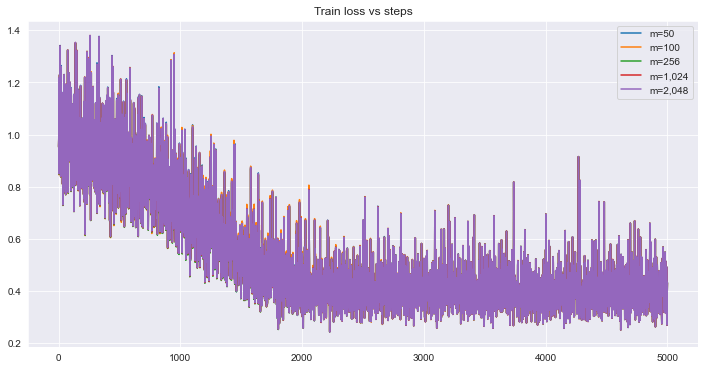

In [18]:
figure = plt.figure(figsize=(12, 6))
for width in widths:
    plt.plot(np.arange(len(training_results[width]['train_losses'])), training_results[width]['train_losses'],
             label='m={:,}'.format(width))
    
plt.legend()
plt.title('Train loss vs steps')
plt.show()

The true loss is equalt to $(1/2)[\mathbb{E}[f^*(y)^2]- 2 w_\lambda(t)^\top \bar{X}_f + v_\rho ||w_\lambda(t)||^2 ] = (1/2)[1 + \left[||w_\lambda(t)||^2 - 2 w_\lambda(t)^\top w^\star \right]] / d$

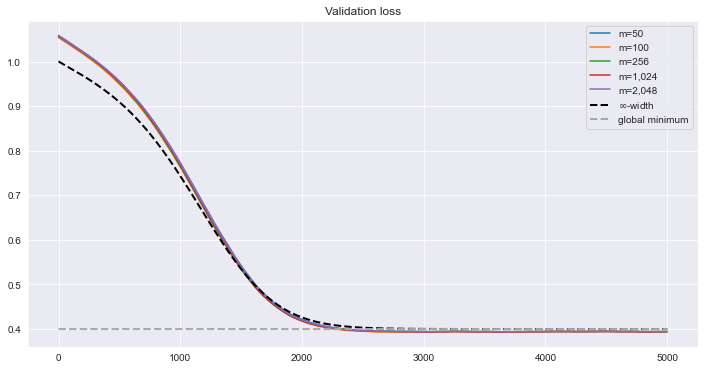

In [19]:
# CONVERGENCE of w(t) towards w_star
figure = plt.figure(figsize=(12, 6))

for width in widths:
    plt.plot(np.arange(len(training_results[width]['val_losses'])), training_results[width]['val_losses'],
             label='m={:,}'.format(width))

delta_lambdas = np.array(w_lambdas) - w_star.reshape(1, -1)
squared_norm_delta_lambdas = np.sum(delta_lambdas ** 2, axis=1)
# theoretical_losses = 0.5 * (1 - (norm_w_star**2) / input_dim + squared_norm_delta_lambdas / input_dim)
theoretical_losses = 0.5 * (2 + (squared_norm_delta_lambdas - norm_w_star**2) / input_dim)

plt.plot(np.arange(len(delta_lambdas)), theoretical_losses, label='$\\infty$-width', color='k', 
         linestyle='dashed', linewidth=2.0)

plt.plot(np.arange(len(delta_lambdas)), [0.5*(2 - (norm_w_star**2) / input_dim )]*len(delta_lambdas), 
         label='global minimum', color='darkgrey', linestyle='dashed', linewidth=2.0)

plt.title('Validation loss')
plt.legend()
plt.show()

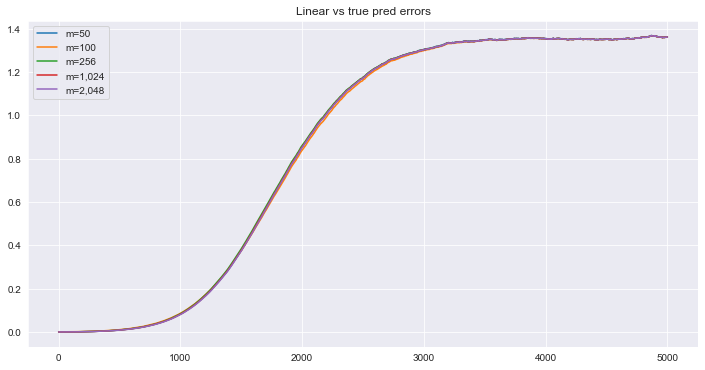

In [20]:
figure = plt.figure(figsize=(12, 6))
for width in widths:
    y_hat_vals = training_results[width]['y_hat_vals']
    ws = training_results[width]['ws'][1:, :]
    lin_preds = np.matmul(ws, np.transpose(X_val.detach().numpy()))
    
    deltas = lin_preds - y_hat_vals.reshape(y_hat_vals.shape[0], y_hat_vals.shape[1])
    errors = np.mean(deltas ** 2, axis=1)


    plt.plot(np.arange(len(errors)), errors, label='m={:,}'.format(width))
plt.title('Linear vs true pred errors')
plt.legend()
plt.show()

In [21]:
#figure = plt.figure(figsize=(12, 6))
#xs = np.arange(len(lambdas))
#plt.plot(xs, lambdas, label='$\\Lambda_k$')
#plt.title('$\\Lambda_k$ vs $k$')
#plt.legend()
#plt.show()

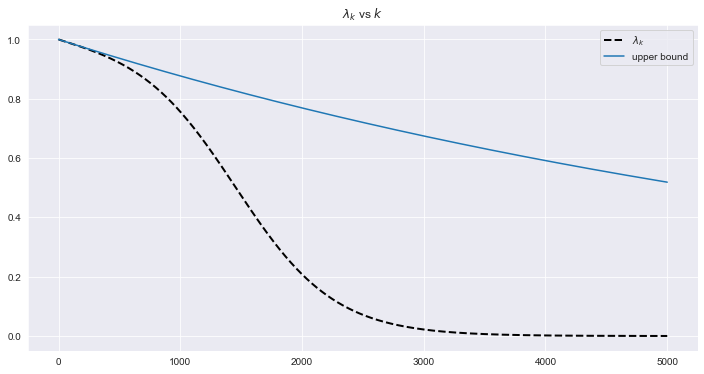

In [22]:
figure = plt.figure(figsize=(12, 6))
xs = np.arange(len(lambda_primes))
plt.plot(xs, lambda_primes, label='$\\lambda_k$', color='k', linestyle='dashed', linewidth=2.0)
plt.plot(xs, np.exp([- V / (4 * input_dim) * base_lr * k for k in xs]), label='upper bound')
plt.title('$\\lambda_k$ vs $k$')
plt.legend()
plt.show()

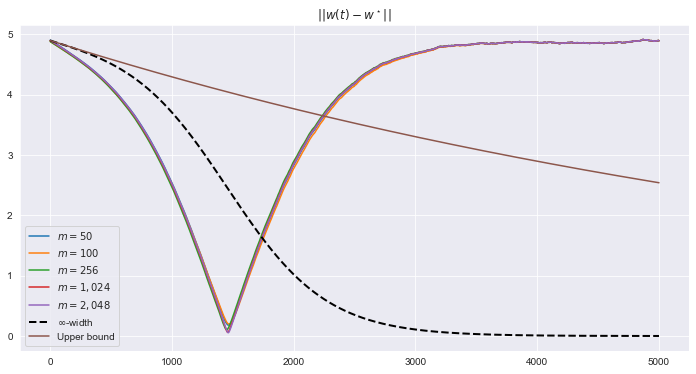

In [23]:
# CONVERGENCE of w(t) towards w_star
figure = plt.figure(figsize=(12, 6))
delta_lambdas = np.array(w_lambdas) - w_star.reshape(1, -1)

for width in widths:
    deltas = training_results[width]['ws'] - w_star.reshape(1, -1)
    plt.plot(np.arange(len(deltas)), np.sqrt(np.sum(deltas ** 2, axis=1)), label='$m={:,}$'.format(width))

plt.plot(np.arange(len(delta_lambdas)), np.sqrt(np.sum(delta_lambdas ** 2, axis=1)), label='$\\infty$-width',
         color='k', linestyle='dashed', linewidth=2.0)
plt.plot(xs, norm_w_star * np.exp([- V / (4 * input_dim) * base_lr * k for k in xs]), label='Upper bound')
plt.title('$||w(t) - w^\star||$')
plt.legend()
plt.show()

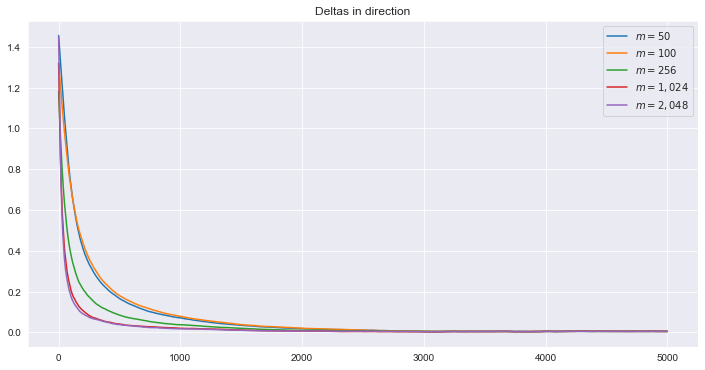

In [24]:
# CONVERGENCE of w(t) towards w_star in DIRECTION
figure = plt.figure(figsize=(12, 6))
delta_lambdas = np.array(w_lambdas) - w_star.reshape(1, -1)

for width in widths:
    ws = training_results[width]['ws'][1:, :]
    ws_normalized = ws / np.linalg.norm(ws, ord=2, axis=1, keepdims=True)
    deltas = ws_normalized - (w_star.reshape(1, -1) / norm_w_star)
    plt.plot(np.arange(len(deltas)), np.sqrt(np.sum(deltas ** 2, axis=1)), label='$m={:,}$'.format(width))

plt.title('Deltas in direction')
plt.legend()
plt.show()